# Södermanland	
# Sthlm

![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [14]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [15]:
#Parameters
n=20
starting_week = 10-4 #start week
first_case = 9
T_max = 48 #length of prediction
pv = 0.023 #fraction of infected that are admitted
rho = 7*1/5.1 #latency period
gamma = 7*1/5 #recovery rate
delay = 3 #2.5 #delay from infection to admission

In [16]:
file = pd.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx', sheet_name = "Inskrivna i slutenvård")
data = [['Sthlm',           8, 2389923, 'SE-AB',  6524],
        ['VGR',             9, 1725881,  'SE-O', 23800],
        ['Skåne',          10, 1387650,  'SE-M', 10968],
        ['Östergötland',   11,  467095,  'SE-E', 10559],
        ['Jönköping',      12,  364750,  'SE-F',  8190],
        ['Södermanland',   13,  299101,  'SE-D', 10437],
        ['Uppsala',        14,  387628,  'SE-C',  5427],
        ['Gävleborg',      15,  287660,  'SE-X',  8504],
        ['Västmanland',    16,  277074,  'SE-U',  6075],
        ['Örebro',         17,  305726,  'SE-T', 28029],
        ['Norrbotten',     18,  249768, 'SE-BD', 18118],
        ['Dalarna',        19,  287806,  'SE-W', 17519],
        ['Västernorrland', 20,  244855,  'SE-Y',  5118],
        ['Värmland',       21,  282840,  'SE-S', 54665],
        ['Halland',        22,  336132,  'SE-N', 97239],
        ['Kalmar',         23,  245992,  'SE-H', 11165],
        ['Kronoberg',      24,  202163,  'SE-G', 21549],
        ['Västerbotten',   25,  273061,  'SE-AC', 8424],
        ['Jämtland',       26,  130972,  'SE-Z',  2931],
        ['Blekinge',       27,  159349,  'SE-K', 48935],
        ['Gotland',        28,   60106,  'SE-I',  3135]] 
regions = pd.DataFrame(data, columns = ['region', 'index','population', 'regionkod', 'area']) 
regions['density'] = regions['population']/regions['area']
first_cases = first_case*np.ones(21).astype(int) #week number when first case was recorded
regions['first case'] = first_cases
starting_weeks = first_cases - 3

regions.drop(regions.index[[20]],inplace=True) #remove Gotland


In [17]:
def getData(name, first_case):
    temp = regions.loc[regions['region'] == name] #find the right row
    index = temp['index'].values #find the region index
    N = temp['population'].values[0] #find population size of region
    R = file.iloc[index[0]] 
    R = R.replace(' ', 0) #replace missing data with 0
    R = R.replace('X', 0) 
    R = R.replace('IU', 0) 
    
    ind = np.arange(3, len(R), 2) 
    I = R.iloc[ind].values #extract admissions
    I = I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10 - first_case + 3) 
    I = np.insert(I, 0, padding) 
    veckor = np.arange(0, len(I), 1) #create array of week numbers
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(name, starting_week):
    df = pd.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp = regions.loc[regions['region'] == name] 
    code = temp['regionkod'].values 
    temp2 = df.loc[df['iso_3166_2_code'] == code[0]]
    transit = temp2['transit_stations_percent_change_from_baseline'].values 
    dagar = np.arange(46, 46 + len(transit))
    tv = np.ceil(dagar / 7)
    
    
    gveckor = np.unique(tv)
    k = 0
    Tr = np.zeros(int(max(gveckor) - min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-starting_week, Tr, kind = "linear", fill_value = "extrapolate")
    #print(Tr)
    return Trfkn

In [18]:
def loadMobility_list(name_list, starting_week):
    Trfkn_dict = dict()
    for i in name_list:
       Trfkn_dict[i] = loadMobility(i, starting_week) 
    return Trfkn_dict


def getData_list(name_list, first_case):
    getData_dict = dict()
    for i in name_list:
        I, veckor, N = getData(i, first_case)
        getData_dict[i] =  {'I': I, 'veckor': veckor, 'N': N}
    return getData_dict

# 2. Correlation Analysis

In [19]:
name_list = regions.region.tolist()
Trfkn_dict = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 

In [20]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict[region_name[0]]['I'])/regions[regions.region == region_name[0]].density.values

for j in getData_dict.keys():
    if j == region_name[0]:
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regions[regions.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [21]:
df.columns = region_name
df.head()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.101002,0.124111,0.0,0.0,0.0,0.0,0.056002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df.corr()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
Sthlm,1.000000,0.843206,0.707943,0.968330,0.911792,0.912002,0.906437,0.851443,0.919852,0.608364,0.916373,0.942713,0.767337,0.609362,0.797345,0.845498,0.634756,0.777421,0.834126,0.277613
VGR,0.843206,1.000000,0.887548,0.728929,0.583918,0.913086,0.903484,0.892073,0.902264,0.570380,0.880070,0.705631,0.886026,0.854733,0.793608,0.925145,0.855745,0.805349,0.664991,0.540573
Skåne,0.707943,0.887548,1.000000,0.621677,0.400992,0.826470,0.836551,0.770706,0.844795,0.357385,0.694584,0.537343,0.825453,0.701450,0.634010,0.837116,0.895035,0.708041,0.714445,0.703238
Östergötland,0.968330,0.728929,0.621677,1.000000,0.949446,0.843867,0.836592,0.758317,0.858380,0.558964,0.861616,0.937252,0.634197,0.456047,0.695051,0.749121,0.519094,0.666688,0.848179,0.214819
Jönköping,0.911792,0.583918,0.400992,0.949446,1.000000,0.742007,0.728714,0.634586,0.728252,0.546562,0.769218,0.934666,0.496379,0.328326,0.611534,0.626122,0.309441,0.592080,0.726492,0.029500
Södermanland,0.912002,0.913086,0.826470,0.843867,0.742007,1.000000,0.935397,0.890879,0.919812,0.666803,0.861836,0.819782,0.839591,0.734929,0.810330,0.888893,0.747598,0.818094,0.757545,0.496441
Uppsala,0.906437,0.903484,0.836551,0.836592,0.728714,0.935397,1.000000,0.834167,0.951433,0.563244,0.822067,0.805795,0.879517,0.724591,0.791194,0.910907,0.725122,0.833061,0.812731,0.496166
Gävleborg,0.851443,0.892073,0.770706,0.758317,0.634586,0.890879,0.834167,1.000000,0.888467,0.611241,0.894599,0.780226,0.822392,0.799760,0.880823,0.863245,0.827918,0.790691,0.698229,0.388709
Västmanland,0.919852,0.902264,0.844795,0.858380,0.728252,0.919812,0.951433,0.888467,1.000000,0.591124,0.874052,0.816632,0.876964,0.703475,0.832255,0.882670,0.768168,0.795805,0.850684,0.471452
Örebro,0.608364,0.570380,0.357385,0.558964,0.546562,0.666803,0.563244,0.611241,0.591124,1.000000,0.661141,0.610308,0.579358,0.611706,0.725711,0.523089,0.391109,0.514327,0.427815,0.262842


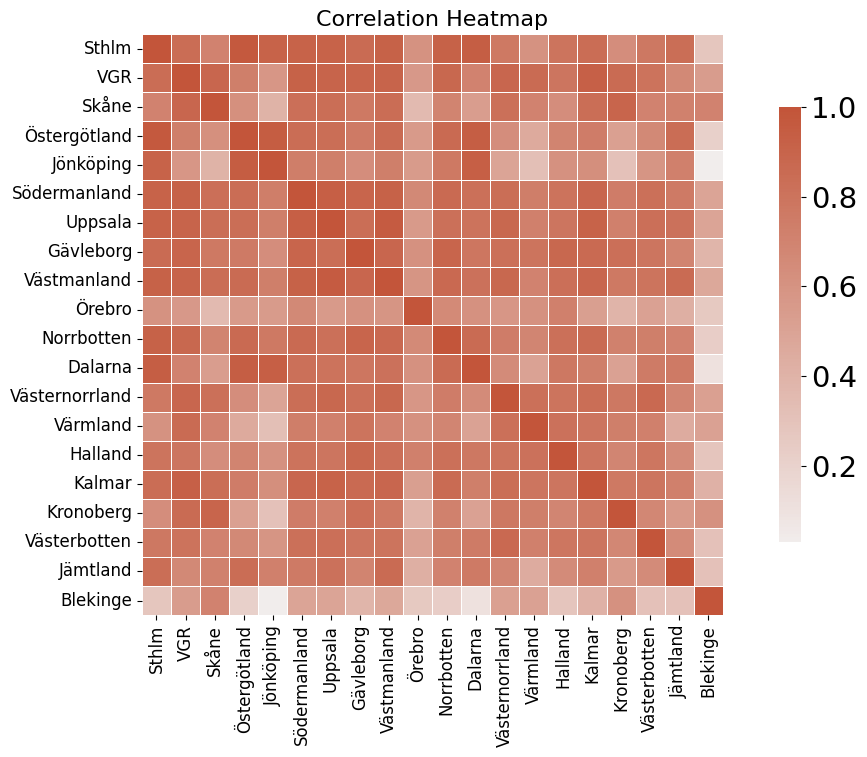

In [23]:
import seaborn as sns


corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
           # show correlation coefficients
    fmt=".2f",        # format for annotations
    linewidths=0.5,   # space between cells
    square=True,      # keep the cells square
    cbar_kws={"shrink": 0.75},  # color bar size
    center=0   ,
    annot_kws={"size": 8}       # center the colormap at zero
)

# Add title and tweak layout
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../data/correlation_heatmap.svg", format="svg")

# Display the plot
plt.show()

In [24]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

,Sthlm
Sthlm,1.000000
Östergötland,0.968330
Dalarna,0.942713
Västmanland,0.919852
Norrbotten,0.916373
Södermanland,0.912002
Jönköping,0.911792
Uppsala,0.906437
Gävleborg,0.851443
Kalmar,0.845498


In [25]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

,Skåne
Skåne,1.000000
Kronoberg,0.895035
VGR,0.887548
Västmanland,0.844795
Kalmar,0.837116
Uppsala,0.836551
Södermanland,0.826470
Västernorrland,0.825453
Gävleborg,0.770706
Jämtland,0.714445


In [26]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

,Uppsala
Uppsala,1.000000
Västmanland,0.951433
Södermanland,0.935397
Kalmar,0.910907
Sthlm,0.906437
VGR,0.903484
Västernorrland,0.879517
Östergötland,0.836592
Skåne,0.836551
Gävleborg,0.834167


# 3. Modeling

#### S[Sthlm]=x0      

#### E[Sthlm]=x1       

#### I[Sthlm]=x2       

#### R[Sthlm]=x3

#### S[Södermanland]=x4      

#### E[Södermanland]=x5       

#### I[Södermanland]=x6       

#### R[Södermanland]=x7

In [27]:
name_list = ['Sthlm', 'Södermanland']
transit_fkn_dct = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 
region_0 = name_list[0]
region_1 = name_list[1]
I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[region_0]['veckor'] 

def beta(t, a, b, transit_fkn):
    return a + b * transit_fkn(t)

def dx(x, t, N, a, b, c, lag):
    S0, E0, I0, R0, S1, E1, I1, R1 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

    dS0 =  - S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1])
    dS1 =  - S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0])
    dE0 =    S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1]) - rho*E0
    dE1 =    S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0]) - rho*E1
    dI0 =  rho*E0 - gamma*I0
    dI1 =  rho*E1 - gamma*I1
    dR0 =  gamma*I0
    dR1 =  gamma*I1

    return [dS0, dE0, dI0, dR0,
            dS1, dE1, dI1, dR1]

def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]

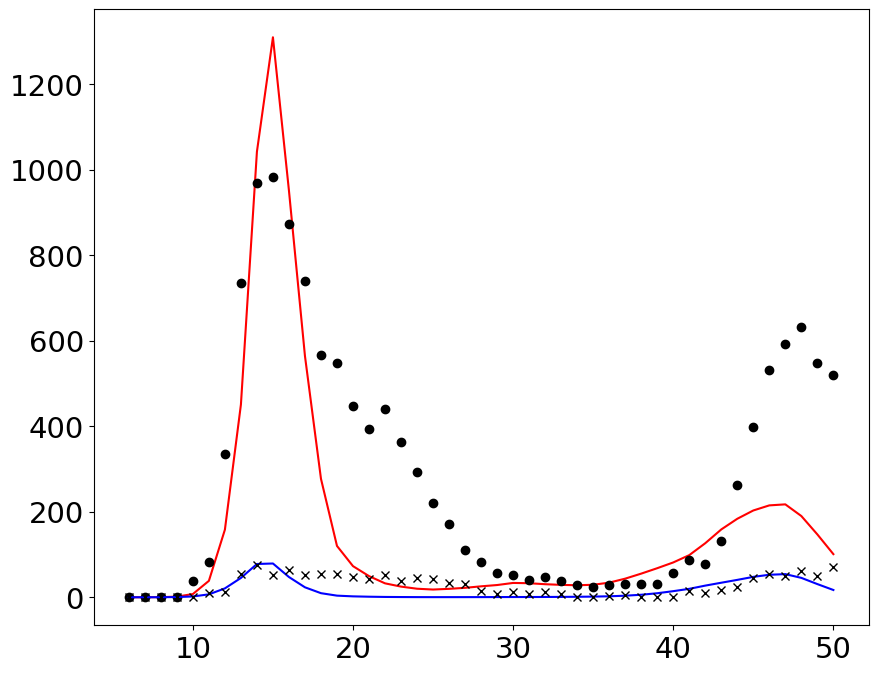

In [28]:
a = [4.759494, 3.51321353491882]
b = [9.215190, 8.31602766854372]
c = 0
P = pred_inlagda(weeks_train, a[0], b[0], a[1], b[1], c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")
axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")

In [29]:
def return_RMSE(P, I):
    return np.sqrt(np.mean((P - I)**2))

def return_CV_RMSE(P, I):
    return 100 * return_RMSE(P, I) / np.mean(I)

In [30]:
print(return_RMSE(P[:,0], I_train[0]))
print(return_RMSE(P[:,1], I_train[1]))
print(return_CV_RMSE(P[:,0], I_train[0]))
print(return_CV_RMSE(P[:,1], I_train[1]))

213.13377135289534
23.71617047039272
75.9083475336786
87.12062621776917


In [40]:
I_train

[array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
        448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
        23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
        521], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 0, 9, 13, 54, 76, 53, 63, 53, 54, 54, 47, 42,
        53, 38, 45, 43, 33, 30, 14, 7, 12, 8, 13, 7, 0, 0, 4, 6, 0, 0, 0,
        15, 10, 16, 24, 44, 54, 50, 61, 50, 70], dtype=object)]

In [41]:
weeks_train

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [160]:
def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]


def return_cv_rmse(I_train, P, ah0, bh0, ah1, bh1, c):
    P = pred_inlagda(weeks_train, ah0, bh0, ah1, bh1,c, delay)
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    return CV_RMSE_1 + CV_RMSE_2

def return_rmse(I_train, P, ah0, bh0, ah1, bh1, c):
    P = pred_inlagda(weeks_train, ah0, bh0, ah1, bh1,c, delay)
    RMSE_1 = return_RMSE(P[:,0], I_train[0])
    RMSE_2 = return_RMSE(P[:,1], I_train[1])
    return RMSE_1 + RMSE_2


def return_curve_fit_cv_rmse(weeks_train, ah0, bh0, ah1, bh1, c):
    P = pred_inlagda(weeks_train, ah0, bh0, ah1, bh1,c, delay)
    norm_mae_0 = np.abs(P[:,0]-I_train[0])/np.mean(I_train[0]) # I_train is Global Variable
    norm_mae_1 = np.abs(P[:,1]-I_train[1])/np.mean(I_train[1])
    combined = np.concatenate((norm_mae_0, norm_mae_1))
    return np.array(combined, dtype=float)


In [123]:
ah0, bh0, ah1, bh1, c = 2.962, 6.689, 2.914, 8.539, 0.7342
return_rmse(I_train, P, ah0, bh0, ah1, bh1, c)

283.05558081857237

In [172]:
veckor = np.arange(0,len(I_train[0]),1) #define week numbers
veckor_train = veckor 
y_data = np.zeros(90)
ah0, bh0, ah1, bh1, c = 2.696, 2.608, 3.901, 14.621, 0.5648
fit, cov = curve_fit(return_curve_fit_cv_rmse,veckor_train,y_data,p0=(ah0, bh0, ah1, bh1, c  ))

In [173]:
ah0, bh0, ah1, bh1, c = fit[0], fit[1], fit[2], fit[3], fit[4]

In [174]:
def return_rmse(I_train, P, ah0, bh0, ah1, bh1, c):
    P = pred_inlagda(weeks_train, ah0, bh0, ah1, bh1,c, delay)
    RMSE_1 = return_RMSE(P[:,0], I_train[0])
    RMSE_2 = return_RMSE(P[:,1], I_train[1])
    return RMSE_1, RMSE_2


In [175]:
return_rmse(I_train, P, ah0, bh0, ah1, bh1, c)

(165.85079683741446, 25.603069671883564)

In [165]:
weeks_train

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [166]:
213.13377135289534
23.71617047039272

23.71617047039272

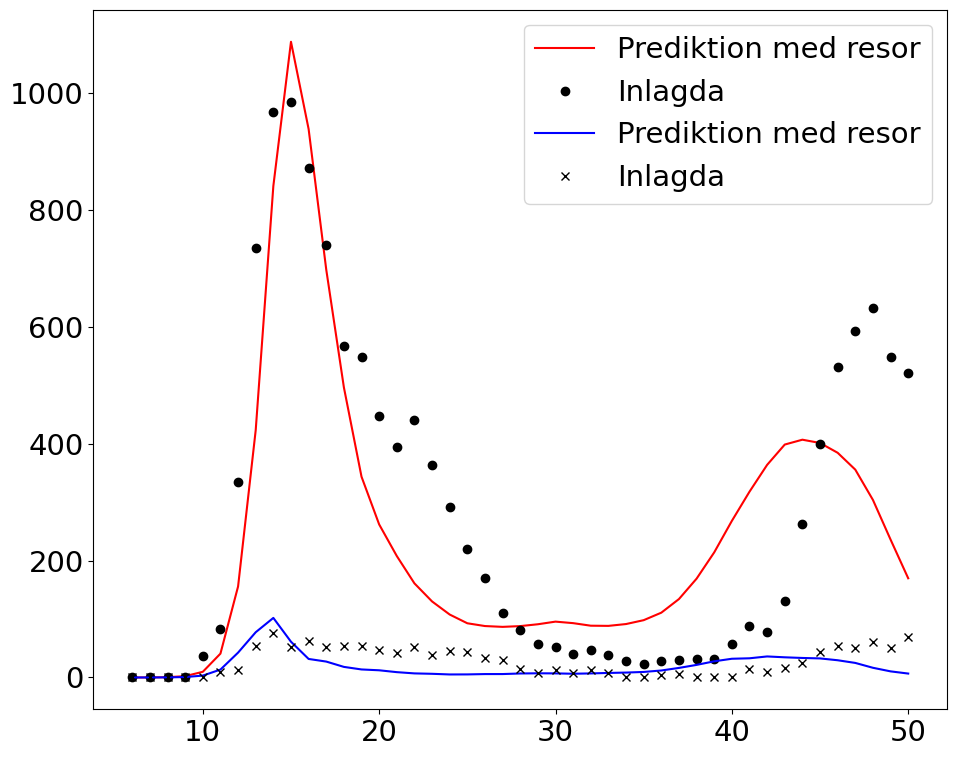

In [167]:
P = pred_inlagda(weeks_train, ah0, bh0, ah1, bh1, c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")
axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")
axes.legend()

# Show plot
plt.tight_layout()
plt.show()

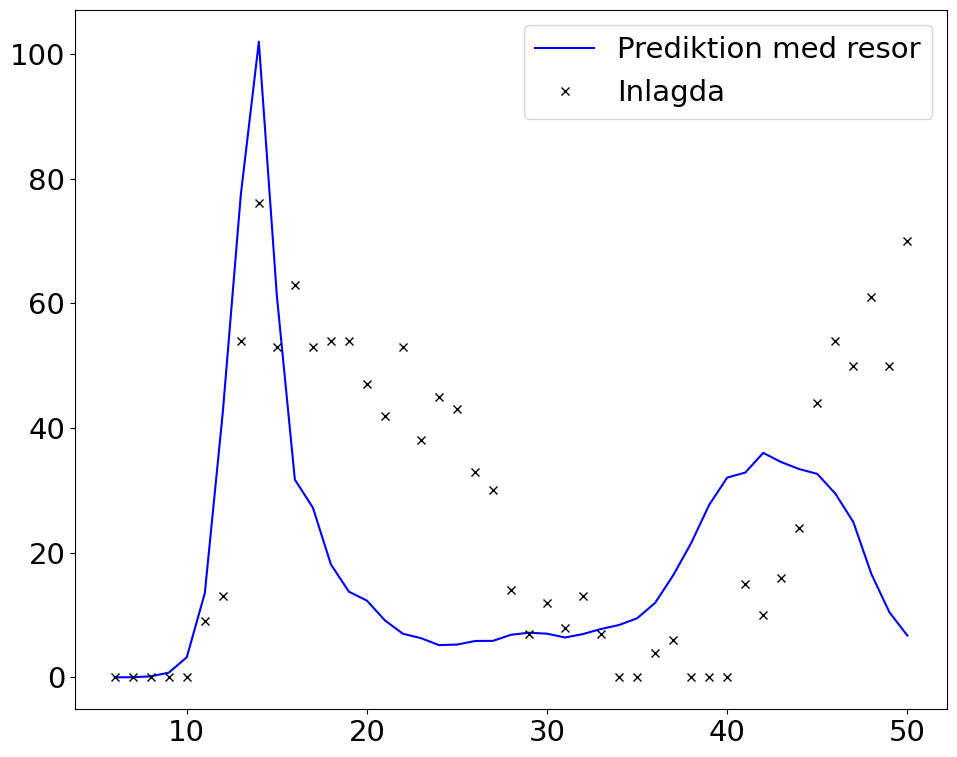

In [168]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")
axes.legend()

# Show plot
plt.tight_layout()
plt.show()

In [169]:
P = pred_inlagda(weeks_train, 4.752653, 8.985473, ah1, bh1, 0, delay)


In [171]:
return_rmse(I_train, P, 4.752653, 8.985473, 3.544680 , 8.425909 , 0)

(182.08878446985207, 23.838740929121386)